In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir

import os

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

In [27]:
config_path = f"config_rsvnet_emcee.yml"
config_path = f"config_CACOMD_maternal_v8_emcee.yml"
run_id = config_path.split(".")[0]

config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = f"emcee_{run_id}"

out_prefix = in_prefix

write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

nsubpop = len(modinf.subpop_struct.subpop_names)
subpop_names = modinf.subpop_struct.subpop_names

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_CACOMD_maternal_v8_emcee.yml


In [28]:
# find what to perturb
fitted_params = {
    "ptype":[],
    "pname":[],
    "subpop":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
ndim=0

print(f"there are {nsubpop} subpop in the config")

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        for sp in modinf.subpop_struct.subpop_names:
            fitted_params["ptype"].append("snpi")
            fitted_params["pname"].append(npi)
            fitted_params["subpop"].append(sp)
            fitted_params["pdist"].append(c["value"].as_random_distribution())
            fitted_params["lb"].append(c["value"]["a"].get())
            fitted_params["ub"].append(c["value"]["b"].get())
            ndim+=1
        print(f" >> {npi} has perturbation, recording")
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        for sp in modinf.subpop_struct.subpop_names:
            fitted_params["ptype"].append("hnpi")
            fitted_params["pname"].append(npi)
            fitted_params["subpop"].append(sp)
            fitted_params["pdist"].append(c["value"].as_random_distribution())
            fitted_params["lb"].append(c["value"]["a"].get())
            fitted_params["ub"].append(c["value"]["b"].get())
            ndim+=1
        print(f" >> {npi} has perturbation, recording")


# TODO: does not support the subpop groups here !!!!!!!
print(f"The dimension of the parameter space is {ndim}!!")

there are 3 subpop in the config
SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj_age0to11m has perturbation, recording
 >> IHRadj_age1to4 has perturbation, recording
 >> IHRadj_age5to17 has perturbation, recording
 >> IHRadj_age18to49 has perturbation, recording
 >> IHRadj_age50to64 has perturbation, recording
 >> IHRadj_age65to100 has perturbation, recording
The dimension of the parameter space is 33!!


In [4]:
# Find the ground-truth
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

## Create the first gempyor object

In [5]:

print("MAKING A TEST RUN TO GET SETUP")
(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.get_from_config(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.get_from_config(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

outcomes_df_ref = outcomes_df_ref.set_index("date")
print("TEST RUN IS DONE")

MAKING A TEST RUN TO GET SETUP


INFO:root:[SEIR.compartments] completed in 4.01 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s


ERROR: subpop_names Connecticut (idx: pl_idx) has a population from initial condition of 3565285.0 while population from geodata is 3565287 (absolute difference should be < 1, here is 2.0)
 Ignoring the previous population mismatch errors because you added flag 'ignore_population_checks'. This is dangerous


INFO:root:Integrating with method rk4.jit
5480it [00:50, 107.77it/s]


TEST RUN IS DONE


In [6]:
import xarray as xr

In [7]:
p_draw.shape

(92, 10959, 9)

In [8]:
modinf.subpop_pop

array([ 3565287, 10617423,  9986857,  5639632,  2096829, 19453561,
        4217737,  6829174,  3205958])

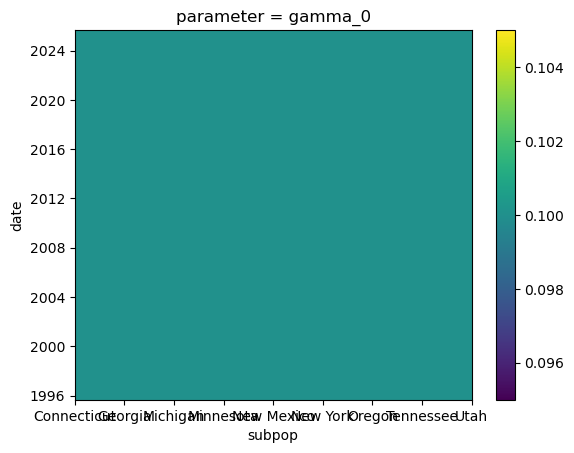

In [9]:
xr.DataArray(p_draw, dims=["parameter", "date", "subpop"],  
                coords={"parameter":modinf.parameters.pnames, 
                "date":pd.date_range(modinf.ti, modinf.tf, freq="D"), 
                "subpop":modinf.subpop_struct.subpop_names}).sel(parameter="gamma_0").plot()

In [10]:
# need to convert to numba dict to python dict so it is pickable
seeding_data = dict(seeding_data)

In [11]:
if False:
    outcomes_df = run_simulation(snpi_df_in=snpi_df_ref, hnpi_df_in=hnpi_df_ref)
    outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
    outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [12]:
#proposal = np.random.random(size=ndim)
#print(log_prob(proposal))
#proposal = np.random.random(size=ndim)*2
#print(log_prob(proposal))

In [13]:
nwalkers = 10

# find the initial point from the chain:
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:,i] = fitted_params["pdist"][i](nwalkers)
    # DOES not take subpop groups into consideration !!!!!!

In [14]:
#print(fitted_params["lb"])
#print(p0)
#print(fitted_params["ub"])

In [15]:
subpop="Minnesota"
gt_s = gt[gt["subpop"]==subpop]
gt_s.sort_index()

,subpop,incidH_0_0.99,incidH_18_49,incidH_1_4,incidH_50_64,incidH_5_17,incidH_65_100
date,,,,,,,
2008-10-11,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-10-18,Minnesota,NaN,3.0,NaN,0.0,NaN,0.0
2008-10-25,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-11-01,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-11-08,Minnesota,NaN,0.0,NaN,3.0,NaN,0.0
...,...,...,...,...,...,...,...
2024-01-13,Minnesota,78.0,12.0,46.0,12.0,6.0,43.0
2024-01-20,Minnesota,74.0,10.0,22.0,12.0,0.0,50.0
2024-01-27,Minnesota,52.0,3.0,22.0,9.0,2.0,35.0


In [16]:
import emcee

from multiprocessing import Pool
from gempyor_logprob import log_prob, compute_likelyhood, check_in_bounds, run_simulation, input_proposal



print(f"initial run llik {compute_likelyhood(outcomes_df_ref, gt, modinf, statistics)}")


initial run llik -110018287.22859603


In [17]:
for i in range(nwalkers):
    assert check_in_bounds(p0[i], fitted_params)

In [21]:
filename = f"{run_id}_backend.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, False], 
                                    pool=pool,
                                    backend=backend, moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(p0, 2, progress=True, skip_initial_state_check=True)

INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integratin

llik is -92370918.08591719
llik is -107044507.89176464
llik is -100844739.85537621
llik is -118826055.08411455
llik is -102307296.24667336
llik is -83216405.01655293
llik is -110159465.52001618
llik is -119323397.50683081
llik is -91650671.12701648
llik is -85743553.44122986


  0%|          | 0/2 [00:00<?, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5480it [00:49, 109.88it/s]
5480it [00:50, 108.32it/s]


llik is -84090995.56846854
llik is -106793247.17973909
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
5480it [00:53, 101.56it/s]
 50%|█████     | 1/2 [02:20<02:20, 140.45s/it]

llik is -118077995.404557
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5480it [00:50, 107.49it/s]
5480it [00:51, 105.74it/s]
5480it [00:53, 101.74it/s]


llik is -98363149.90377766
llik is -97848253.14302434
llik is -113433576.39073531
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5480it [00:51, 106.78it/s]
5480it [00:51, 106.11it/s]
5480it [00:52, 104.64it/s]


llik is -112163572.70795591
llik is -80198878.65300132


100%|██████████| 2/2 [04:41<00:00, 140.91s/it]

llik is -113336419.99436621


In [24]:
backend = emcee.backends.HDFBackend(filename)
nsamples = 10 # number of likelyhood eval to write to disk...
with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, True], 
                                    pool=pool,
                                    backend=backend,  moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(None, (nsamples//nwalkers)+1, progress=True, skip_initial_state_check=True)

  0%|          | 0/2 [00:00<?, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
5480it [00:52, 105.35it/s]


llik is -95633022.17718527
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5480it [00:49, 111.76it/s]
5480it [00:51, 105.44it/s]


llik is -109149213.13151728


 50%|█████     | 1/2 [02:30<02:30, 150.10s/it]

llik is -101163982.8630643


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5480it [00:49, 110.33it/s]
5480it [00:51, 107.30it/s]


llik is -100033354.24918354
llik is -105417953.93065067
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
5480it [00:50, 109.22it/s]
100%|██████████| 2/2 [04:54<00:00, 147.07s/it]

llik is -92036566.60696286


In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

#print(
#    "Mean autocorrelation time: {0:.3f} steps".format(
#        np.mean(sampler.get_autocorr_time())
#    )
#)

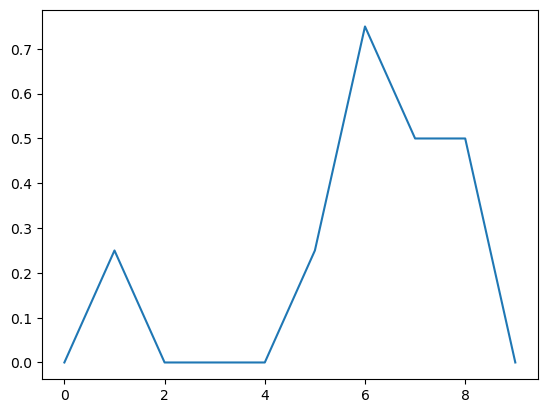

In [25]:
plt.plot(sampler.acceptance_fraction)

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_92656/2723658821.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


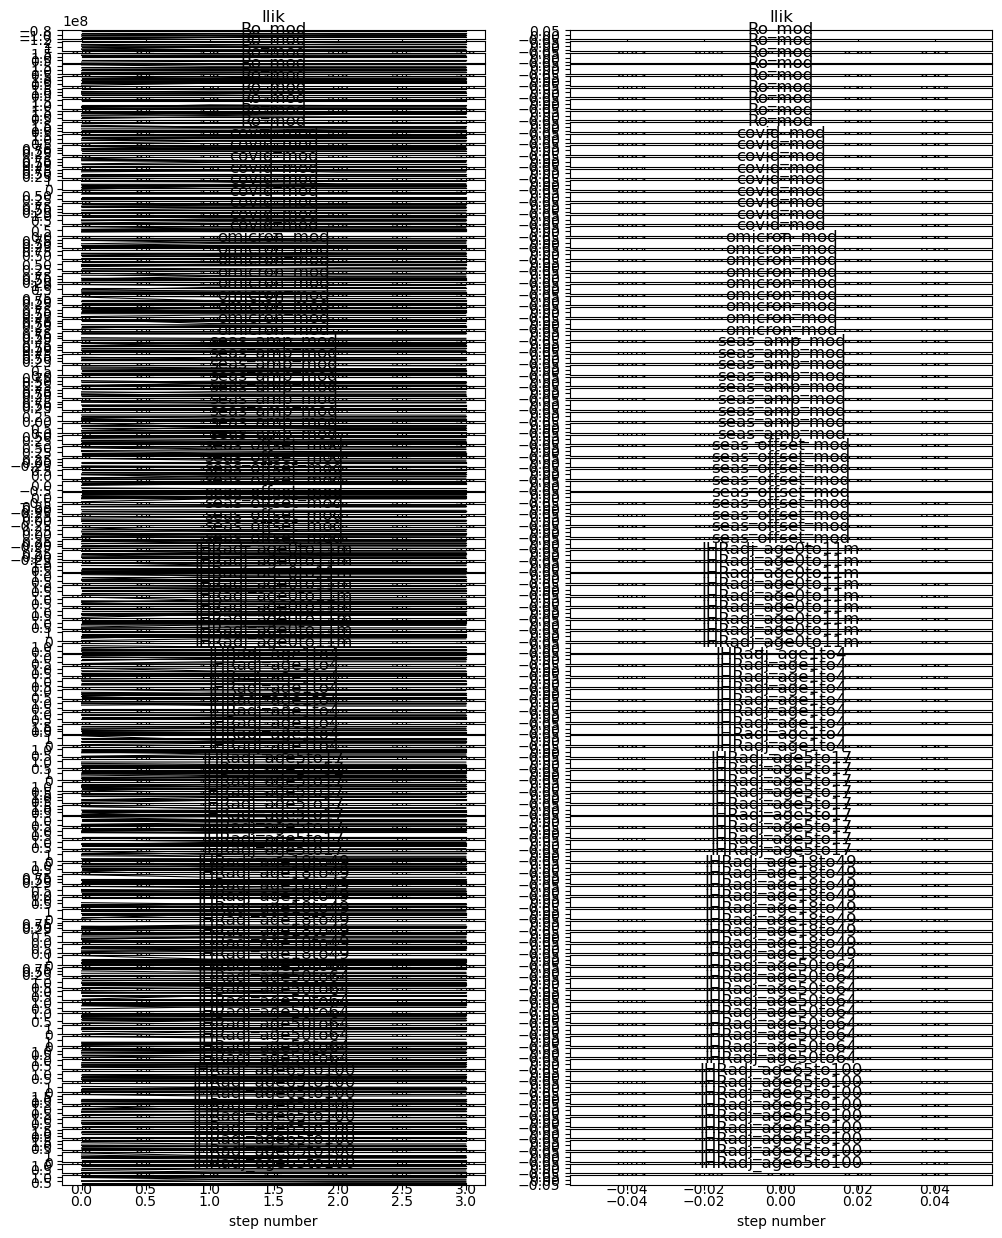

In [26]:
fig, axes = plt.subplots(ndim+1,2, figsize=(12, 15))
samples = sampler.get_chain()
labels = fitted_params["pname"]


def plot_chain(frompt,axes):
    ax = axes[0]
    ax.plot(sampler.get_log_prob()[frompt:], "k", alpha=1, lw=.8)
    ax.set_title("llik")
    #ax.set_xlim(0, len(samples))

    for i in range(ndim):
        ax = axes[i+1]
        ax.plot(samples[frompt:, :, i], "black", alpha=1, lw=.8,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(40,axes[:,1])
fig.tight_layout()

In [ ]:
plt.plot(sampler.get_log_prob());


In [ ]:
plt.plot(sampler.get_log_prob());

In [ ]:
np.mean(sampler.get_log_prob()[-1,:])

In [ ]:
np.mean(sampler.get_log_prob()[-1,:])

In [ ]:
samples.shape

In [ ]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

In [ ]:
fig, axes = plt.subplots(len(statistics), figsize=(12, 12), sharex=True, dpi=300)
for subpop in modinf.subpop_struct.subpop_names:
        gt_s = gt[gt["subpop"]==subpop].sort_index()
        first_date = max(gt_s.index.min(),results[0].index.min())
        last_date = min(gt_s.index.max(), results[0].index.max())
        gt_s = gt_s.loc[first_date:last_date].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes.flat[i]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[first_date:last_date].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(value)

In [ ]:
emcee.__version__

In [ ]:
import corner

In [ ]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=100, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);